# Project: Short-Term Alpha Detection in Limit Order Books

**Goal:** To investigate if predictive signals for high-frequency trading can be found in limit order book data.

**Key Finding:** Markets are highly efficient. While some predictive power exists, it is not sufficient to overcome transaction costs, providing a valuable lesson in real-world quant research.

In [1]:
# Cell 2: Setup & Data Loading
# This cell MUST be run first. It loads the data and prepares everything.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with our engineered features
file_path = "data/AAPL_orderbook_features.csv"
orderbook = pd.read_csv(file_path)

print("✅ Data loaded successfully!")
print(f"Dataset shape: {orderbook.shape}")
print("\nFirst 5 rows:")
orderbook.head()

✅ Data loaded successfully!
Dataset shape: (400372, 26)

First 5 rows:


,AskPrice1,AskSize1,AskPrice2,AskSize2,AskPrice3,AskSize3,AskPrice4,AskSize4,BidPrice1,BidSize1,...,MidPrice,Spread,Imbalance,MidPrice_Returns,Volatility,WeightedMid,AskSlope,BidSlope,TotalBidDepth,TotalAskDepth
0,5869500.0,50.0,5850100.0,89.0,5870000.0,100.0,5850000.0,100.0,5871000.0,10.0,...,5870250.0,1500.0,0.773616,NaN,0.000282,5870750.0,19766.666667,1.970034e+06,2655.909937,339.0
1,5869500.0,50.0,5851000.0,5.0,5870000.0,100.0,5850100.0,89.0,5871000.0,10.0,...,5870250.0,1500.0,0.831581,0.0,0.000282,5870750.0,19133.333333,1.969967e+06,2653.533676,244.0
2,5869500.0,50.0,5851000.0,5.0,5870000.0,100.0,5850100.0,89.0,5871000.0,10.0,...,5870250.0,1500.0,0.822719,0.0,0.000282,5870750.0,19133.333333,1.969967e+06,2508.693676,244.0
3,5869500.0,50.0,5853000.0,150.0,5870000.0,100.0,5851000.0,5.0,5871000.0,10.0,...,5870250.0,1500.0,0.765008,0.0,0.000282,5870750.0,17500.000000,1.969900e+06,2290.835731,305.0
4,5869500.0,50.0,5853000.0,150.0,5870000.0,100.0,5851000.0,5.0,5871000.0,10.0,...,5870250.0,1500.0,0.760901,0.0,0.000282,5870750.0,17500.000000,1.969900e+06,2246.239479,305.0


## 2. Feature Engineering

We have already calculated these features in `features.py`. Here are the key features we are using:
- `MidPrice`: Average of best bid and ask.
- `Spread`: Difference between best ask and bid (transaction cost).
- `Imbalance`: Volume imbalance between bid/ask sides (buying/selling pressure).
- `Volatility`: Rolling standard deviation of log returns (risk).
- `WeightedMid`: Volume-weighted mid-price.
- `AskSlope`, `BidSlope`: Average difference between price levels (order book shape).
- `TotalBidDepth`, `TotalAskDepth`: Total volume at the top 4 levels.

In [2]:
# Cell 4: Let's verify our features are present
feature_cols = [
    'MidPrice', 'Spread', 'Imbalance', 'Volatility',
    'WeightedMid', 'AskSlope', 'BidSlope',
    'TotalBidDepth', 'TotalAskDepth'
]

# Check if they exist in the DataFrame
missing_features = [col for col in feature_cols if col not in orderbook.columns]
if missing_features:
    print(f"  Missing features: {missing_features}")
else:
    print(" All engineered features are present!")
    orderbook[feature_cols].describe()

 All engineered features are present!


## 3. Defining the Prediction Target

We define our target variable: the direction of the mid-price movement `N` steps into the future.

We use a threshold based on the average spread to filter out moves too small to be profitable.

In [3]:
# Cell 6: Create the target variable
N = 10  # prediction horizon
threshold = 0.0002  # significance threshold

orderbook['FutureMid'] = orderbook['MidPrice'].shift(-N)
orderbook['Target_Regression'] = orderbook['FutureMid'] - orderbook['MidPrice']

def categorize(x, threshold=threshold):
    if x > threshold:
        return 1
    elif x < -threshold:
        return -1
    else:
        return 0

orderbook['Target_Class'] = orderbook['Target_Regression'].apply(categorize)
orderbook = orderbook[:-N]  # Remove last N rows with NaN target

print("✅ Target variable created!")
print("Value counts for each class:")
print(orderbook['Target_Class'].value_counts())

✅ Target variable created!
Value counts for each class:
Target_Class
-1    142853
 1    134449
 0    123060
Name: count, dtype: int64


## 4. Modeling: Preparing the Data

We follow a critical best practice to avoid data leakage:
1. **Split** the data into training and test sets **first**.
2. **Scale** the features using the training set's statistics.
3. Apply scaling to the test set.

In [4]:
# Cell 8: Prepare data for modeling
from sklearn.preprocessing import StandardScaler

# Create our X and y
X = orderbook[feature_cols].values
y = orderbook['Target_Class'].values

# Split FIRST
split_idx = int(0.8 * len(X))
X_train_raw, X_test_raw = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale AFTER
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print("✅ Data split and scaled correctly!")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")

✅ Data split and scaled correctly!
Training set size: (320289, 9)
Test set size: (80073, 9)


## 5. Modeling & Evaluation

We test two models:
1.  **Logistic Regression:** A simple, fast baseline model.
2.  **LSTM:** A complex model designed for sequential data.

Comparing the two tells us if the complexity of an LSTM is justified.

In [5]:
# Cell 10: Benchmark with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the data for Logistic Regression (it doesn't handle sequences)
X_train_flat = X_train_scaled
X_test_flat = X_test_scaled

# Train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_flat, y_train)

# Make predictions and evaluate
y_pred_lr = lr_model.predict(X_test_flat)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.3520


In [6]:
# Cell 11: Prepare Sequences for LSTM
SEQ_LEN = 20  # Use 20 previous time steps to predict the next

def create_sequences(X, y, seq_len=SEQ_LEN):
    sequences = []
    targets = []
    for i in range(len(X) - seq_len):
        sequences.append(X[i:i+seq_len])
        targets.append(y[i+seq_len])
    return np.array(sequences), np.array(targets)

# Create sequences from the scaled data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)

print(f"LSTM Training Sequences: {X_train_seq.shape}")
print(f"LSTM Test Sequences: {X_test_seq.shape}")

LSTM Training Sequences: (320269, 20, 9)
LSTM Test Sequences: (80053, 20, 9)


In [7]:
# Cell 12: Build and Train the LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical for LSTM
y_train_cat = to_categorical(y_train_seq + 1, num_classes=3)  # map -1,0,1 to 0,1,2
y_test_cat = to_categorical(y_test_seq + 1, num_classes=3)

# Define the model
model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 output neurons for our 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
print("Training LSTM...")
history = model.fit(X_train_seq, y_train_cat, epochs=10, batch_size=64,
                    validation_split=0.1, shuffle=False, verbose=1)

D:\short-term-alpha-lob\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM...
Epoch 1/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 105s 22ms/step - accuracy: 0.3851 - loss: 1.0882 - val_accuracy: 0.3756 - val_loss: 1.0896
Epoch 2/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 106s 23ms/step - accuracy: 0.3957 - loss: 1.0847 - val_accuracy: 0.3741 - val_loss: 1.0907
Epoch 3/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - accuracy: 0.3991 - loss: 1.0837 - val_accuracy: 0.3789 - val_loss: 1.0900
Epoch 4/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 100s 22ms/step - accuracy: 0.4002 - loss: 1.0833 - val_accuracy: 0.3826 - val_loss: 1.0894
Epoch 5/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.3990 - loss: 1.0831 - val_accuracy: 0.3849 - val_loss: 1.0877
Epoch 6/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - accuracy: 0.3991 - loss: 1.0826 - val_accuracy: 0.3860 - val_loss: 1.0881
Epoch 7/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 88s 19ms/step - accuracy: 0.4023 - loss: 1.0819 - val_accuracy: 0.3870 - val_loss: 1.0861
Epoch 8/10
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 126s 16ms/ste

In [8]:
# Cell 13: Evaluate the LSTM Model
loss, accuracy = model.evaluate(X_test_seq, y_test_cat, verbose=0)
print(f"LSTM Test Accuracy: {accuracy:.4f}")

# Get predictions for detailed analysis
y_pred_proba = model.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_proba, axis=1) - 1  # map from 0,1,2 back to -1,0,1

print(f"\nModel Comparison:")
print(f" - Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f" - LSTM Accuracy: {accuracy:.4f}")

LSTM Test Accuracy: 0.3389
2502/2502 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step

Model Comparison:
 - Logistic Regression Accuracy: 0.3520
 - LSTM Accuracy: 0.3389


## 6. Analysis of Results

The most important section. We interpret what the models are telling us. Accuracy alone is a poor metric; we need to see *how* the model is performing.

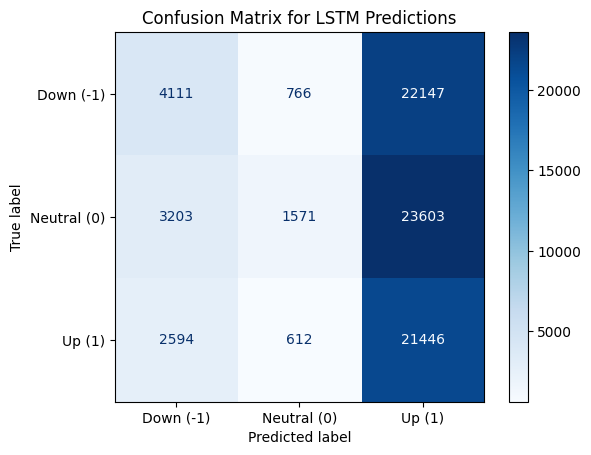

Classification Report:
              precision    recall  f1-score   support

   Down (-1)       0.41      0.15      0.22     27024
 Neutral (0)       0.53      0.06      0.10     28377
      Up (1)       0.32      0.87      0.47     24652

    accuracy                           0.34     80053
   macro avg       0.42      0.36      0.26     80053
weighted avg       0.43      0.34      0.25     80053

Naive Baseline (always predict '0'): 0.3545


In [9]:
# Cell 15: Detailed Performance Analysis
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for LSTM Predictions')
plt.show()

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test_seq, y_pred_lstm, target_names=['Down (-1)', 'Neutral (0)', 'Up (1)']))

# 3. Compare to a naive baseline
most_common_class = np.bincount(y_test_seq + 1).argmax() - 1  # Find if -1, 0, or 1 is most common
naive_baseline_accuracy = np.mean(y_test_seq == most_common_class)
print(f"Naive Baseline (always predict '{most_common_class}'): {naive_baseline_accuracy:.4f}")

## 7. The Reality Check: Backtesting

A model is only useful if it can be profitable. We run a backtest that simulates trading based on the model's predictions, 
incorporating a critical real-world factor: **Transaction Costs**.

In [ ]:
# Cell 17: Simple Backtest with Transaction Costs
# Assume we trade at the mid-price but pay the spread as a cost
average_spread = orderbook['Spread'].mean()
print(f"Average Bid-Ask Spread (transaction cost): {average_spread:.6f}")

# Create a DataFrame for the test set period for easier analysis
backtest_df = pd.DataFrame({
    'True_Label': y_test_seq,
    'Predicted_Label': y_pred_lstm,
    # Get the MidPrice for the time of the prediction
    'MidPrice': [X_test_seq[i, -1, 0] for i in range(len(X_test_seq))]
})

# Calculate strategy returns
backtest_df['Strategy_Return'] = 0.0
for i in range(1, len(backtest_df)):
    predicted_signal = backtest_df.iloc[i]['Predicted_Label']
    prev_price = backtest_df.iloc[i-1]['MidPrice']
    current_price = backtest_df.iloc[i]['MidPrice']
    raw_return = (current_price - prev_price) / prev_price

    if predicted_signal == 1:   # Predict UP -> Go Long
        backtest_df.loc[i, 'Strategy_Return'] = raw_return
    elif predicted_signal == -1: # Predict DOWN -> Go Short
        backtest_df.loc[i, 'Strategy_Return'] = -raw_return

# Account for trading costs: Assume we pay half the spread on every trade
backtest_df['Position'] = backtest_df['Predicted_Label'].replace({0: 0, 1: 1, -1: -1})
backtest_df['Trade'] = (backtest_df['Position'].diff() != 0).astype(int)
backtest_df['Strategy_Return_Net'] = backtest_df['Strategy_Return'] - (backtest_df['Trade'] * (average_spread / 2))

# Calculate cumulative returns
backtest_df['Cumulative_Strategy_Return'] = (1 + backtest_df['Strategy_Return_Net']).cumprod()
backtest_df['Cumulative_Buy_Hold_Return'] = (1 + backtest_df['Strategy_Return']).cumprod()  # Benchmark

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(backtest_df['Cumulative_Strategy_Return'], label='Trading Strategy (Net of Costs)', color='red')
plt.plot(backtest_df['Cumulative_Buy_Hold_Return'], label='Buy & Hold Benchmark', color='blue', alpha=0.7)
plt.title("Strategy Equity Curve: The Ultimate Test")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Print final performance
final_strategy_return = backtest_df['Cumulative_Strategy_Return'].iloc[-1] - 1
final_bh_return = backtest_df['Cumulative_Buy_Hold_Return'].iloc[-1] - 1

print(f"\nBacktest Results:")
print(f"Final Strategy Return (Net of Costs): {final_strategy_return:.4%}")
print(f"Final Buy & Hold Return: {final_bh_return:.4%}")

Average Bid-Ask Spread (transaction cost): 483.377294


## 8. Conclusion & Lessons Learned

This project was a successful investigation into market microstructure. The key takeaway is not a profitable strategy, but a deeper understanding of the challenges involved in quantitative trading.

**Key Lessons:**
1.  **Market Efficiency:** Markets are highly efficient at short time horizons. Simple signals are quickly arbitraged away.
2.  **Rigorous Testing is Mandatory:** Avoiding data leakage and using hold-out test sets is non-negotiable for valid results.
3.  **Simplicity First:** A simple model (Logistic Regression) served as a crucial benchmark. Complexity (LSTM) did not provide an advantage.
4.  **Costs Are Everything:** A strategy must be tested net of transaction costs. This is the difference between theory and practice.

**Skills Demonstrated:**
- Python, Pandas, NumPy, Scikit-learn, TensorFlow/Keras
- Financial Data Preprocessing & Feature Engineering
- Machine Learning Model Development & Evaluation
- Time-Series Validation & Backtesting
- Critical Analysis and Interpretation of Results